In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler

from pandas.api.types import CategoricalDtype

In [2]:
np.random.seed(0)
IMPUTATION_REQUIRED=0
TRAIN_SIZE=0.8
PAR_NORMALIZE=0
PAR_SCALE=1
target_col = 'galtan' # 'lrgen', 'lrecon', 'galtan'
target_factor = target_col + '_factor' # 'lrgen_factor', 'lrecon_factor', 'galtan_factor'
# check if data is imputed or not
IMPUTED_DATA = 'No' # 'Yes' if imputed
SOURCE_DATA_FILES = 'data/base_data/' #'data/imputed_data/recategorized/imputation_cart/'
FILE_SUFFIX = '' #'_recategorized'

In [3]:
#data_raw = pd.read_csv("data/CHES2019_experts_imputed_cart.csv", index_col=0).reset_index(drop=True)
data_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_train' + FILE_SUFFIX + '.csv', index_col = 0)
data_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_train' + FILE_SUFFIX + '.csv', index_col = 0)
if IMPUTED_DATA == 'Yes':
    valid_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_valid' + FILE_SUFFIX + '.csv', index_col = 0)
    valid_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_valid' + FILE_SUFFIX + '.csv', index_col = 0)
test_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_test' + FILE_SUFFIX + '.csv', index_col = 0)
test_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_test' + FILE_SUFFIX + '.csv', index_col = 0)
#data = pd.read_csv("data/CHES2019_experts_imputed_pmm.csv")

# Data preprocessing
Preprocessing steps (after imputation in R)

In [4]:
# split data into training and test dataset
# split data for obtaining a separated TEST dataset (not used for training)
X_train = data_X
X_test = test_X
y_train = data_y
y_test = test_y

In [5]:
# standardization/normalization of data
# Be aware: information related to scaling MUST NOT flow into the separated datasets
# --> 1st split, 2nd scaling
if (PAR_NORMALIZE==1):
    data_normalized = preprocessing.normalize(X_train)

if (PAR_SCALE==1):
    scaler = preprocessing.StandardScaler().fit(X_train)
    data_scaled = scaler.transform(X_train)

In [6]:
X_train_base = X_train
y_train_base = y_train

# Oversampling to balance the dataset regarding target variable

In [7]:
#samplers = [
#    FunctionSampler(),
#    RandomOverSampler(random_state=0),
#    SMOTE(random_state=0),
#    ADASYN(random_state=0),
#]


#X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train_base, y_train_base)
X_train, y_train = SMOTE(random_state=0, sampling_strategy='not majority').fit_resample(X_train_base, y_train_base)
#X_train, y_train = ADASYN(random_state=0, sampling_strategy='minority').fit_resample(X_train_base, y_train_base)


#for sampler in samplers:
#    sampler.fit_resample(X_train, y_train)




In [8]:
y_train.value_counts()

galtan_factor
0.0              288
1.0              288
2.0              288
3.0              288
4.0              288
5.0              288
6.0              288
7.0              288
8.0              288
9.0              288
10.0             288
dtype: int64

# Principal Component Analysis: reduce dimensionality

In [9]:
# create a PCA with 2 components
# combine the result with the target result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 
                                        'PC2'],
                          index=X_train.index)
finalDf = pd.concat([principalDf, y_train], axis = 1)


In [10]:
finalDf[target_factor].factorize()[0]

array([0, 1, 2, ..., 3, 3, 3])

In [11]:
finalDf.head()

,PC1,PC2,galtan_factor
0,-5.165161,-0.458997,2.0
1,-4.156748,0.451948,3.0
2,-1.438595,1.289266,5.0
3,6.992592,0.170386,10.0
4,-0.720762,1.836361,4.0


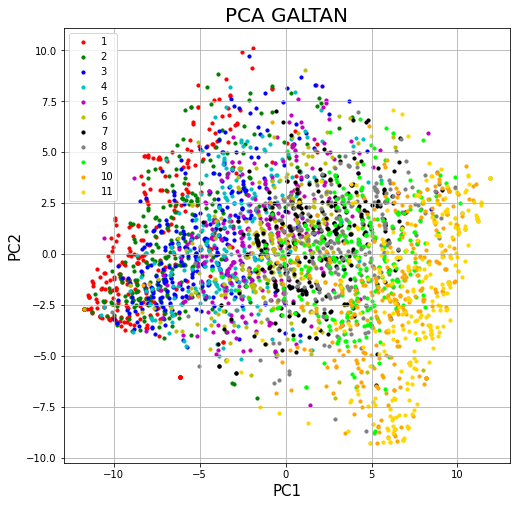

In [12]:
# visualize the results of the PCA
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA GALTAN', fontsize = 20)

targets = range(0,12)
colors = ['r', 'g', 'b', 'c',  'm',  'y',  'k',  'gray',  'lime',  'orange',  'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor] == target #indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

In [13]:
# about 80% of the variance are explained through the 2 components
pca.explained_variance_ratio_

array([0.61268234, 0.20345104])

In [14]:
len(indicesToKeep)

3168

# Clustering
Check if some patterns can be observed using unsupervised learning

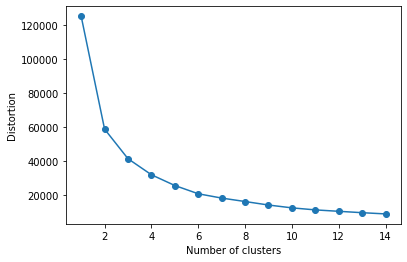

In [15]:
# try to obtain best number of clusters through scree plot
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(finalDf[['PC1', 'PC2']])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [16]:
# try to cluster results of PCA
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(finalDf[['PC1', 'PC2']])

In [17]:
y_km

array([1, 1, 0, ..., 2, 3, 2], dtype=int32)

In [18]:
cluster_data = pd.concat([finalDf, 
                          pd.DataFrame(y_km, 
                                       index=X_train.index, 
                                       columns=['cluster'])], 
                         axis=1)

In [19]:
cluster_data.head(20)
#cluster_data[cluster_data['lrgen_factor']==10]['cluster'].value_counts()

,PC1,PC2,galtan_factor,cluster
0,-5.165161,-0.458997,2.0,1
1,-4.156748,0.451948,3.0,1
2,-1.438595,1.289266,5.0,0
3,6.992592,0.170386,10.0,3
4,-0.720762,1.836361,4.0,0
5,-10.011805,-1.244389,0.0,1
6,-3.230924,7.823607,0.0,0
7,-9.737732,-2.412205,0.0,1
8,-4.288128,0.992552,3.0,1
9,-6.359948,-1.738761,0.0,1


In [20]:
cluster_data.pivot_table(aggfunc='count', columns = [target_factor, 'cluster']).T

PC1  PC2
galtan_factor cluster          
0.0           0         56   56
              1        232  232
1.0           0         71   71
              1        215  215
              2          1    1
              3          1    1
2.0           0        104  104
              1        177  177
              2          3    3
              3          4    4
3.0           0        134  134
              1        134  134
              2          8    8
              3         12   12
4.0           0        179  179
              1         82   82
              2         17   17
              3         10   10
5.0           0        203  203
              1         41   41
              2         26   26
              3         18   18
6.0           0        138  138
              1         11   11
              2         64   64
              3         75   75
7.0           0         93   93
              1          6    6
              2         77   77
              3        112  112
8.0           0         57   57
              1          3    3
              2        103  103
              3        125  125
9.0           0         13   13
              1          3    3
              2        151  151
              3        121  121
10.0          0          4    4
              1          2    2
              2        133  133
              3        149  149

# Supervised learning: various algorithms
### Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/

## 1) Support Vector Classification

CHECK: RMSE and other scoring mechanisms

In [21]:
########### PARAMETERS 
scoring_method = 'balanced_accuracy'#['balanced_accuracy', 'f1_samples', 'roc_auc_ovo_weighted']
cv_nr = 5

In [22]:
# CROSS-VALIDATION (without TEST dataset)

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.34858044 0.33911672 0.34542587 0.32385466 0.35229068]
0.34 accuracy with a standard deviation of 0.01


In [23]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
# Create the parameter grid
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__degree': [1,2,3,4,5]
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
# Create an instance of GridSearch Cross-validation estimator
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the SVM classifier
gsSVC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsSVC.best_score_)
# Print the model parameters of the best model
print(gsSVC.best_params_)
# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsSVC.score(X_test, y_test))
# Print the model score on the test data using Best estimator instance
clfSVC = gsSVC.best_estimator_
#print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))

0.46857504262222954
{'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
Test accuracy: 0.308


## Random Forest Classification

In [24]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1, criterion='entropy')) 
# Create the parameter grid
                            
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':range(5, 105, 5)#,
    #'randomforestclassifier__criterion:':['gini', 'entropy']
}]
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsRFC.best_score_)
# Print the model parameters of the best model
print(gsRFC.best_params_)
# Print the test score of the best model
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

0.4640983336083154
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__n_estimators': 65}
Test accuracy: 0.384


In [25]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## Logistic Regression Classification

In [26]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
# Create an instance of GridSearch Cross-validation estimator
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsLR.best_score_)
# Print the model parameters of the best model
print(gsLR.best_params_)
# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

0.34145080569762964
{'logisticregression__C': 1.0}
Test accuracy: 0.332


## ADABoost Classification (Ensemble Method)

In [27]:
pipelineADAB = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
# Create the parameter grid
param_grid_ADAB = [{
    'adaboostclassifier__n_estimators': [2, 10, 20, 30, 40, 50, 100]
}]
# Create an instance of GridSearch Cross-validation estimator
gsADAB = GridSearchCV(estimator=pipelineADAB,
                     param_grid = param_grid_ADAB,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsADAB = gsADAB.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsADAB.best_score_)
# Print the model parameters of the best model
print(gsADAB.best_params_)
# Print the test score of the best model
clfADAB = gsADAB.best_estimator_
print('Test accuracy: %.3f' % clfADAB.score(X_test, y_test))

0.300280481768685
{'adaboostclassifier__n_estimators': 10}
Test accuracy: 0.304


In [28]:
gsADAB.scoring

'balanced_accuracy'

# Test models with independent dataset

In [29]:
#scaler = preprocessing.StandardScaler().fit(test_X)
#test_X_scaled = scaler.transform(test_X)

In [30]:
sklearn.metrics.accuracy_score(test_y, gsADAB.predict(test_X))

0.3044982698961938

In [31]:
sklearn.metrics.confusion_matrix(test_y, gsADAB.predict(test_X))

array([[11, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 20,  1,  1,  2,  0,  0,  0,  0,  0,  0],
       [ 3, 13,  1,  4,  7,  0,  0,  0,  0,  0,  0],
       [ 2,  6,  0,  5,  7,  0,  1,  0,  1,  1,  0],
       [ 0,  3,  0,  5, 14,  1,  3,  0,  1,  2,  0],
       [ 2,  4,  1,  1,  8,  0,  2,  0,  6,  0,  1],
       [ 0,  0,  0,  3,  3,  0,  3,  0,  8,  0,  0],
       [ 0,  0,  0,  0,  3,  2,  2,  0, 19,  1,  6],
       [ 0,  1,  0,  0,  3,  0,  2,  1, 13,  4,  5],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  6,  3, 12],
       [ 0,  1,  0,  0,  0,  1,  0,  0,  5,  2, 18]])

In [32]:
sklearn.metrics.mean_squared_error(test_y, gsADAB.predict(test_X))

3.612456747404844

In [33]:
sklearn.metrics.f1_score(test_y, gsADAB.predict(test_X), average='weighted')

0.2492013305863002

In [34]:
sklearn.metrics.accuracy_score(test_y, gsLR.predict(test_X))

0.33217993079584773

In [35]:
sklearn.metrics.confusion_matrix(test_y, gsLR.predict(test_X))

array([[20,  5,  1,  1,  0,  0,  0,  0,  0,  0,  0],
       [16,  6,  3,  1,  3,  0,  0,  0,  0,  0,  0],
       [ 9,  4,  8,  5,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  2,  9,  5,  3,  2,  1,  1,  0,  0,  0],
       [ 0,  3,  2,  5,  9,  5,  5,  0,  0,  0,  0],
       [ 2,  1,  3,  3,  2,  3,  6,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  7,  1,  3,  3,  1,  0],
       [ 0,  0,  0,  0,  0,  1,  8, 12,  8,  3,  1],
       [ 0,  0,  0,  0,  1,  2,  4,  2, 11,  7,  2],
       [ 0,  0,  0,  0,  0,  0,  1,  2,  6,  5,  8],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  6,  4, 16]])

In [36]:
sklearn.metrics.mean_squared_error(test_y, gsLR.predict(test_X))

2.2975778546712804

In [37]:
sklearn.metrics.f1_score(test_y, gsLR.predict(test_X), average='weighted')

0.32724939975939926

In [38]:
sklearn.metrics.accuracy_score(test_y, gsRFC.predict(test_X))

0.38408304498269896

In [39]:
sklearn.metrics.confusion_matrix(test_y, gsRFC.predict(test_X))

array([[18,  8,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 9, 13,  3,  3,  1,  0,  0,  0,  0,  0,  0],
       [ 3, 11,  5,  6,  2,  1,  0,  0,  0,  0,  0],
       [ 0,  2,  6,  7,  4,  2,  0,  1,  0,  1,  0],
       [ 1,  0,  5,  1,  7, 13,  2,  0,  0,  0,  0],
       [ 1,  2,  3,  3,  1,  4, 10,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  1,  4,  5,  2,  3,  1,  0],
       [ 0,  0,  0,  0,  0,  1, 11,  9,  9,  3,  0],
       [ 0,  0,  0,  1,  1,  1,  3,  3, 16,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  2,  5, 10,  4],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  2,  7, 17]])

In [40]:
sklearn.metrics.mean_squared_error(test_y, gsRFC.predict(test_X))

2.13840830449827

In [41]:
sklearn.metrics.f1_score(test_y, gsRFC.predict(test_X), average='weighted')

0.38397640524787996

In [42]:
sklearn.metrics.accuracy_score(test_y, gsSVC.predict(test_X))

0.3044982698961938

In [43]:
sklearn.metrics.confusion_matrix(test_y, gsSVC.predict(test_X))

array([[15, 10,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [14,  8,  3,  3,  1,  0,  0,  0,  0,  0,  0],
       [ 4,  6,  6,  7,  4,  1,  0,  0,  0,  0,  0],
       [ 0,  2,  7,  6,  4,  1,  1,  2,  0,  0,  0],
       [ 1,  1,  4,  3,  6, 12,  0,  2,  0,  0,  0],
       [ 2,  0,  2,  3,  5,  5,  6,  0,  2,  0,  0],
       [ 0,  0,  1,  1,  4,  2,  5,  0,  3,  1,  0],
       [ 0,  0,  0,  3,  2,  5,  4,  5, 11,  2,  1],
       [ 0,  0,  1,  2,  1,  4,  2,  2, 10,  6,  1],
       [ 0,  0,  0,  0,  0,  0,  2,  2,  4,  8,  6],
       [ 0,  0,  2,  0,  0,  2,  1,  0,  2,  6, 14]])

In [44]:
sklearn.metrics.mean_squared_error(test_y, gsSVC.predict(test_X))

3.328719723183391

In [45]:
sklearn.metrics.f1_score(test_y, gsSVC.predict(test_X), average='weighted')

0.3030966468021178

In [46]:
#pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
#pipeline.fit(X_train, y_train)

In [47]:
#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [48]:
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#pipe.fit(X_train, y_train)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
#pipe.score(X_test, y_test)

In [49]:
### Write several scores to the output ###

RMSE = True
model_vector = [gsADAB, gsLR, gsRFC, gsSVC]
for model in model_vector:
    print(model.estimator.named_steps)
    print('Accuracy Score: ', sklearn.metrics.accuracy_score(test_y, model.predict(test_X)))
    print('Balanced Accuracy Score: ', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    print('Cohen-Kappa-Score: ', sklearn.metrics.cohen_kappa_score(test_y, model.predict(test_X)))
    print('F1-Score: ', sklearn.metrics.f1_score(test_y, model.predict(test_X), average='weighted'))
    if RMSE == True:
        print('RMSE: ', sklearn.metrics.mean_squared_error(test_y, model.predict(test_X)))
        #print('ROC-AUC-Score: ', sklearn.metrics.roc_auc_score(test_y, 
        #                                                       model.predict(test_X), 
        #                                                       average='weighted', 
        #                                                       multi_class='ovo'))
    print('__________________________________\n')

for model in model_vector:
    print('Confusion matrix: \n', sklearn.metrics.confusion_matrix(test_y, model.predict(test_X)))

for model in model_vector:
    print(sklearn.metrics.classification_report(test_y, model.predict(test_X)))

{'standardscaler': StandardScaler(), 'adaboostclassifier': AdaBoostClassifier(random_state=1)}
Accuracy Score:  0.3044982698961938
Balanced Accuracy Score:  0.29642759490068454
Cohen-Kappa-Score:  0.23215513139110677
F1-Score:  0.2492013305863002
RMSE:  3.612456747404844
__________________________________

{'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(random_state=1)}
Accuracy Score:  0.33217993079584773
Balanced Accuracy Score:  0.3184293879867483
Cohen-Kappa-Score:  0.2648345854751549
F1-Score:  0.32724939975939926
RMSE:  2.2975778546712804
__________________________________

{'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(criterion='entropy', random_state=1)}
Accuracy Score:  0.38408304498269896
Balanced Accuracy Score:  0.3819986577846418
Cohen-Kappa-Score:  0.3231582963830376
F1-Score:  0.38397640524787996
RMSE:  2.13840830449827
__________________________________

{'standardscaler': StandardScaler(), 'svc': SVC

In [50]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

Features:            ['econ_interven' 'environment' 'redistribution' 'civlib_laworder'
 'immigrate_policy' 'sociallifestyle']
Feature Importance:  [0.09580584 0.12843131 0.09803198 0.21353792 0.16422007 0.29997287]


In [51]:
from joblib import dump, load
dump(gsRFC, 'models/gsRFC_galtan_fulltarget_NoImputation.joblib') 
#clf = load('filename.joblib')


['models/gsRFC_galtan_fulltarget_NoImputation.joblib']